# Computing uncertainties from the strain rate fits. 

- load data
- compute profiles and velocities, $w$
- extract only $w$ in the region we want to fit
- fit with numpy, scipy, xarray
- examine the cross-correlation matrices we get from them 


In [2]:
import sys
sys.path.append("../../../xapres")
import xapres as xa
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.optimize import curve_fit
import xarray as xr

## Load the data and extract one chirp crop

### load

In [3]:
fd = xa.load.from_dats()
data_directory = '/Users/jkingslake/Documents/projects/current_projects/AntPen_NSF_NERC/AntPen_NSF_NERC/data/flask/ApRES Season1/7.12.2024_Site2_unattended/Data'
file_names = fd.list_files(data_directory)
len(file_names)


ds = xa.load.generate_xarray(data_directory, computeProfiles=False)
ds = ds.sortby('time').mean('chirp_num')
ds = ds.assign_coords({"time": ds.time- np.timedelta64(3, 'h')})
ds.time.attrs['long_name'] = 'time (PA time: UTC-3hrs)'
ds_c = ds.isel(time = slice(5,-1))
stacked = ds_c.addProfileToDs()
w = stacked.profile.displacement_timeseries(max_depth_for_ezz_fit = 400, offset = 6)

In [4]:
w

<xarray.Dataset>
Dimensions:                        (shot_number: 2, time: 88,
                                    attenuator_setting_pair: 2,
                                    profile_range: 39999, bin_depth: 1999)
Coordinates:
    filename                       (shot_number, time) <U23 'DATA2024-12-08-1...
    folder_name                    (time) <U4 'Data' 'Data' ... 'Data' 'Data'
    burst_number                   (shot_number, time) int64 0 0 0 0 ... 0 0 0 0
    AFGain                         (time, attenuator_setting_pair) int64 -4 ....
    attenuator                     (time, attenuator_setting_pair) float64 20...
    orientation                    (time) <U7 'unknown' 'unknown' ... 'unknown'
  * profile_range                  (profile_range) float64 0.0 ... 8.411e+03
    profile_time                   (shot_number, time) datetime64[ns] 2024-12...
  * time                           (time) datetime64[ns] 2024-12-08T19:58:36....
  * shot_number                    (shot_number) int64 1 2
  * bin_depth                      (bin_depth) float64 1.998 6.204 ... 8.405e+03
Dimensions without coordinates: attenuator_setting_pair
Data variables: (12/13)
    profile                        (shot_number, time, attenuator_setting_pair, profile_range) complex128 ...
    coherence                      (time, attenuator_setting_pair, bin_depth) complex128 ...
    phase                          (time, attenuator_setting_pair, bin_depth) float64 ...
    phase_uncertainty              (time, attenuator_setting_pair, bin_depth) float64 ...
    displacement                   (time, attenuator_setting_pair, bin_depth) float64 ...
    disp_uncertainty               (time, attenuator_setting_pair, bin_depth) float64 ...
    ...                             ...
    velocity_uncertainty           (time, attenuator_setting_pair, bin_depth) float64 ...
    strain_rate                    (time, attenuator_setting_pair) float64 0....
    strain_rate_uncertainty        (time, attenuator_setting_pair) float64 0....
    surface_intercept              (time, attenuator_setting_pair) float64 -3...
    surface_intercept_uncertainty  (time, attenuator_setting_pair) float64 1....
    r_squared                      (time, attenuator_setting_pair) float64 0....
Attributes:
    long_name:    profile
    units:        -
    description:  Time series of profiles of coherence, phase, displacement, ...
    constants:    {'T': 1, 'f_1': 200000000.0, 'f_2': 400000000.0, 'B': 20000...
    bin_size:     20
    processing:   Created by the displacement_timeseries function in xapres u...
    offset:       6

### extract one chirp and crop

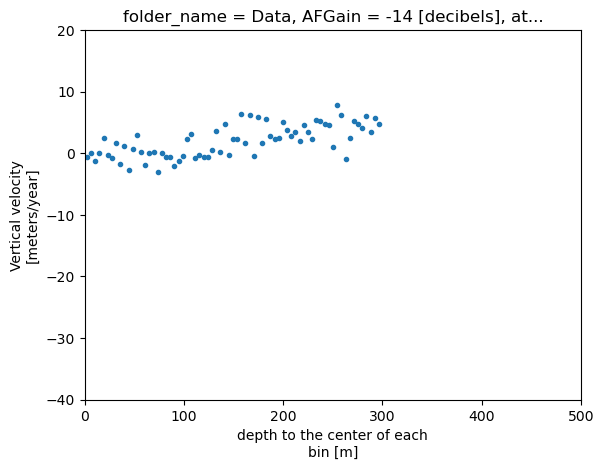

In [5]:
one_w = w.isel(attenuator_setting_pair=1, time=60).sel(bin_depth=slice(0,300))
xdata = one_w.bin_depth.values
ydata = one_w.velocity.values
sigma = one_w.velocity_uncertainty.values
one_w.velocity.plot(xlim=[0,500], ylim=[-40, 20], marker='.', linestyle = 'None')

<ErrorbarContainer object of 3 artists>

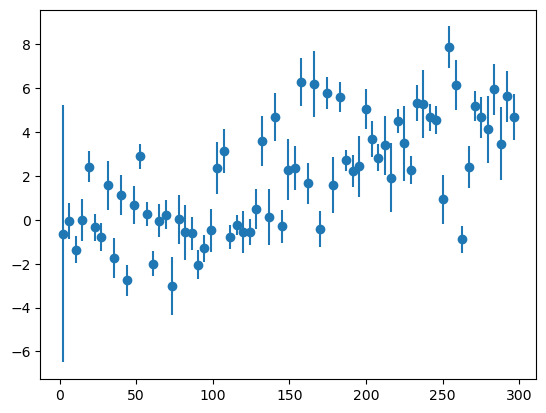

In [6]:
plt.errorbar(x=xdata, y=ydata, yerr=sigma, marker='o', label='data', linestyle='None')

## Fit a linear model to the data
This is an estimate of vertical strain rates.

Do it with scipy, numpy, and xarray and check we get the same answers. 

Also do the fit without weight, with relative weights and absolute weight. 

We should have 9 fits, each with two parameters each with uncertainties. 

### Create dataframe to store results

In [7]:
import pandas as pd
no_weights = pd.DataFrame(index=['slope', 'intercept', 'sigma_slope', 'sigma_intercept'], columns=['scipy', 'numpy', 'xarray', 'apply_ufunc'])
rel_weights = pd.DataFrame(index=['slope', 'intercept', 'sigma_slope', 'sigma_intercept'], columns=['scipy', 'numpy', 'xarray', 'apply_ufunc'])
abs_weights = pd.DataFrame(index=['slope', 'intercept', 'sigma_slope', 'sigma_intercept'], columns=['scipy', 'numpy', 'xarray', 'apply_ufunc'])


### Do the fits with scipy.curvefit

first define a linear function

In [8]:
def func(x, a, c):
    return a * x + c

In [9]:
# no weights
popt, pcov = curve_fit(f = func, xdata=xdata, ydata=ydata)
perr = np.sqrt(np.diag(pcov))
no_weights.scipy.slope = popt[0]
no_weights.scipy.intercept = popt[1]
no_weights.scipy.sigma_slope = perr[0]
no_weights.scipy.sigma_intercept = perr[1]

# relative weights
popt, pcov = curve_fit(f = func, xdata=xdata, ydata=ydata, sigma=sigma, absolute_sigma=False)
perr = np.sqrt(np.diag(pcov))
rel_weights.scipy.slope = popt[0]
rel_weights.scipy.intercept = popt[1]
rel_weights.scipy.sigma_slope = perr[0]
rel_weights.scipy.sigma_intercept = perr[1]

# absolute weights
popt, pcov = curve_fit(f = func, xdata=xdata, ydata=ydata, sigma=sigma, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
abs_weights.scipy.slope = popt[0]
abs_weights.scipy.intercept = popt[1]
abs_weights.scipy.sigma_slope = perr[0]
abs_weights.scipy.sigma_intercept = perr[1]

abs_weights

,scipy,numpy,xarray,apply_ufunc
slope,0.020818,NaN,NaN,NaN
intercept,-1.349183,NaN,NaN,NaN
sigma_slope,0.001144,NaN,NaN,NaN
sigma_intercept,0.185069,NaN,NaN,NaN


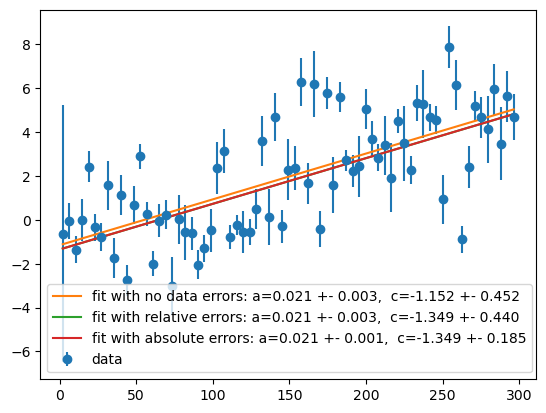

In [10]:
#popt, pcov = curve_fit(f = func, xdata=xdata, ydata=ydata)
#popt_sigma, pcov_sigma = curve_fit(f = func, xdata=xdata, ydata=ydata, sigma=sigma, absolute_sigma=False)
#popt_Abssigma, pcov_Abssigma = curve_fit(f = func, xdata=xdata, ydata=ydata, sigma=sigma, absolute_sigma=True)


plt.errorbar(x=xdata, y=ydata, yerr=sigma, marker='o', label='data', linestyle='None')

def param_str(df, method):
    return f'a={df[method].slope:5.3f} +- {df[method].sigma_slope:5.3f},  c={df[method].intercept:5.3f} +- {df[method].sigma_intercept:5.3f}'

plt.plot(xdata, func(xdata, no_weights.scipy.slope, no_weights.scipy.intercept),
         label=f"fit with no data errors: {param_str(no_weights, 'scipy')}")

plt.plot(xdata, func(xdata, rel_weights.scipy.slope, rel_weights.scipy.intercept),
            label=f"fit with relative errors: {param_str(rel_weights, 'scipy')}")

plt.plot(xdata, func(xdata, abs_weights.scipy.slope, abs_weights.scipy.intercept),
            label=f"fit with absolute errors: {param_str(abs_weights, 'scipy')}")
#perr = np.sqrt(np.diag(pcov_sigma))
#plt.plot(xdata, func(xdata, *popt_sigma),
#         label=f'fit with relative errors: a={popt_sigma[0]:5.3f}+- {perr[0]:5.3f},  c={popt_sigma[1]:5.3f} +- {perr[1]:5.3f}')

#perr = np.sqrt(np.diag(pcov_Abssigma))
#plt.plot(xdata, func(xdata, *popt_Abssigma),
#         label=f'fit with absolute errors: a={popt_Abssigma[0]:5.3f} +- {perr[0]:5.3f},  c={popt_Abssigma[1]:5.3f}+- {perr[1]:5.3f}')
plt.legend();

## Do the fit with numpy

In [11]:
p, residuals, rank, singular_values, rcond = np.polyfit(xdata, ydata, 1, full = True)
residuals

p, V = np.polyfit(xdata, ydata, 1, cov = True)
V

array([[ 6.88244463e-06, -1.02686378e-03],
       [-1.02686378e-03,  2.04339898e-01]])

In [12]:
popt, pcov = np.polyfit(xdata, ydata, 1, cov=True)
perr = np.sqrt(np.diag(pcov))
no_weights.numpy.slope = popt[0]
no_weights.numpy.intercept = popt[1]
no_weights.numpy.sigma_slope = perr[0]
no_weights.numpy.sigma_intercept = perr[1]

popt, pcov = np.polyfit(xdata, ydata, 1, w=1/sigma, cov=True)
perr = np.sqrt(np.diag(pcov))
rel_weights.numpy.slope = popt[0]
rel_weights.numpy.intercept = popt[1]
rel_weights.numpy.sigma_slope = perr[0]
rel_weights.numpy.sigma_intercept = perr[1]

popt, pcov = np.polyfit(xdata, ydata, 1, w=1/sigma, cov='unscaled')
perr = np.sqrt(np.diag(pcov))
abs_weights.numpy.slope = popt[0]
abs_weights.numpy.intercept = popt[1]
abs_weights.numpy.sigma_slope = perr[0]
abs_weights.numpy.sigma_intercept = perr[1]
abs_weights

,scipy,numpy,xarray,apply_ufunc
slope,0.020818,0.020818,NaN,NaN
intercept,-1.349183,-1.349183,NaN,NaN
sigma_slope,0.001144,0.001144,NaN,NaN
sigma_intercept,0.185069,0.185069,NaN,NaN


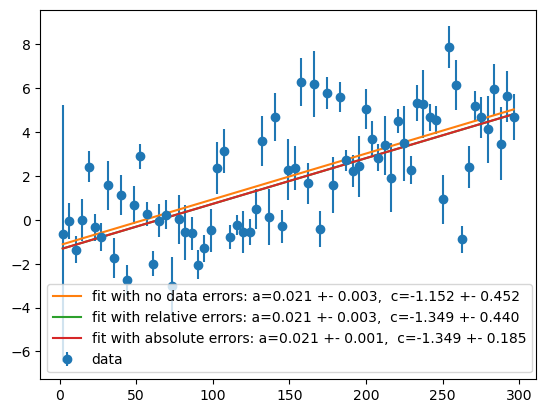

In [13]:
plt.errorbar(x=xdata, y=ydata, yerr=sigma, marker='o', label='data', linestyle='None')

plt.plot(xdata, func(xdata, no_weights.numpy.slope, no_weights.numpy.intercept),
         label=f"fit with no data errors: {param_str(no_weights, 'numpy')}")

plt.plot(xdata, func(xdata, rel_weights.numpy.slope, rel_weights.numpy.intercept),
            label=f"fit with relative errors: {param_str(rel_weights, 'numpy')}")

plt.plot(xdata, func(xdata, abs_weights.numpy.slope, abs_weights.numpy.intercept),
            label=f"fit with absolute errors: {param_str(abs_weights, 'numpy')}")
plt.legend();

## Do the fit with xarray

In [14]:
xarray_fit = one_w.velocity.polyfit('bin_depth', 1, cov = True)
popt = [xarray_fit.sel(degree = 1).polyfit_coefficients.item(), xarray_fit.sel(degree = 0).polyfit_coefficients.item()]
perr = [np.sqrt(np.diag(xarray_fit.polyfit_covariance.squeeze()))[0], np.sqrt(np.diag(xarray_fit.polyfit_covariance.squeeze()))[1]]
no_weights.xarray.slope = popt[0]
no_weights.xarray.intercept = popt[1]
no_weights.xarray.sigma_slope = perr[0]
no_weights.xarray.sigma_intercept = perr[1]

xarray_fit = one_w.expand_dims(foo=1).velocity.polyfit(dim='bin_depth', deg= 1, cov = True, w=1/sigma)
popt = [xarray_fit.sel(degree = 1).polyfit_coefficients.item(), xarray_fit.sel(degree = 0).polyfit_coefficients.item()]
perr = [np.sqrt(np.diag(xarray_fit.polyfit_covariance.squeeze()))[0], np.sqrt(np.diag(xarray_fit.polyfit_covariance.squeeze()))[1]]
rel_weights.xarray.slope = popt[0]
rel_weights.xarray.intercept = popt[1]
rel_weights.xarray.sigma_slope = perr[0]
rel_weights.xarray.sigma_intercept = perr[1]

xarray_fit = one_w.expand_dims(foo=1).velocity.polyfit(dim='bin_depth', deg= 1, cov = 'unscaled', w=1/sigma)
popt = [xarray_fit.sel(degree = 1).polyfit_coefficients.item(), xarray_fit.sel(degree = 0).polyfit_coefficients.item()]
perr = [np.sqrt(np.diag(xarray_fit.polyfit_covariance.squeeze()))[0], np.sqrt(np.diag(xarray_fit.polyfit_covariance.squeeze()))[1]]
abs_weights.xarray.slope = popt[0]
abs_weights.xarray.intercept = popt[1]
abs_weights.xarray.sigma_slope = perr[0]
abs_weights.xarray.sigma_intercept = perr[1]

In [15]:
xarray_fit = one_w.expand_dims(foo=1).velocity.polyfit(dim='bin_depth', deg= 1, cov = 'unscaled', w=1/sigma, full=True)
xarray_fit

<xarray.Dataset>
Dimensions:                    (degree: 2, foo: 1, cov_i: 2, cov_j: 2)
Coordinates:
  * degree                     (degree) int64 1 0
  * foo                        (foo) int64 0
Dimensions without coordinates: cov_i, cov_j
Data variables:
    bin_depth_matrix_rank      int64 2
    bin_depth_singular_values  (degree) float64 1.363 0.3765
    polyfit_coefficients       (degree, foo) float64 0.02082 -1.349
    polyfit_residuals          (foo) float64 390.5
    polyfit_covariance         (cov_i, cov_j) float64 1.309e-06 ... 0.03425

## Implement it with ufuncs

We will need to use apply_ufunc because polyfot does not allow you to use a different vector of weights for each vector of w. 

In [22]:
import xarray as xr


#### no weights ---------------------------------

def polyfit(ds, deg = 1, cov = 'unscaled'):
    # Define a slim wrapper around np.polyfit
    def my_polyfit(x, y, cov, deg=1):
        p, residuals,  rank, singular_values, rcond = np.polyfit(x, y, deg=deg, full=True)
        p, V = np.polyfit(x, y, deg=deg, cov=cov)
        perr = np.sqrt(np.diag(V))
        return p, perr, residuals

    res = xr.apply_ufunc(
        my_polyfit,
        ds.bin_depth,
        ds.velocity,
        input_core_dims=[["bin_depth"], ["bin_depth"]],
        output_core_dims=[["degree"], ["degree"], ["dummy_dim"]],
        kwargs = {'deg': deg, 'cov': cov},
        vectorize=True            
    )
    out = [res[0].rename("parameters"), res[1].rename("parameter_uncertainty") , res[2].squeeze().rename("polyfit_residuals")]
    return xr.merge(out)

p = polyfit(one_w, cov = 'full')

no_weights.apply_ufunc.slope = p.parameters[0].item()
no_weights.apply_ufunc.intercept = p.parameters[1].item()
no_weights.apply_ufunc.sigma_slope = p.parameter_uncertainty[0].item()
no_weights.apply_ufunc.sigma_intercept = p.parameter_uncertainty[1].item()


#### relative weights ---------------------------------

def polyfit(ds, deg = 1, cov = 'unscaled'):
    # Define a slim wrapper around np.polyfit
    def my_polyfit(x, y, sigma, cov, deg=1):
        p, residuals,  rank, singular_values, rcond = np.polyfit(x, y,  w=1/sigma, deg=deg, full=True)
        p, V = np.polyfit(x, y,  w=1/sigma, deg=deg, cov=cov)
        perr = np.sqrt(np.diag(V))
        return p, perr, residuals

    res = xr.apply_ufunc(
        my_polyfit,
        ds.bin_depth,
        ds.velocity,
        ds.velocity_uncertainty,
        input_core_dims=[["bin_depth"], ["bin_depth"], ["bin_depth"]],
        output_core_dims=[["degree"], ["degree"], ["dummy_dim"]],
        kwargs = {'deg': deg, 'cov': cov},
        vectorize=True            
    )
    out = [res[0].rename("parameters"), res[1].rename("parameter_uncertainty") , res[2].squeeze().rename("polyfit_residuals")]
    return xr.merge(out)

p = polyfit(one_w, cov = 'full')

rel_weights.apply_ufunc.slope = p.parameters[0].item()
rel_weights.apply_ufunc.intercept = p.parameters[1].item()
rel_weights.apply_ufunc.sigma_slope = p.parameter_uncertainty[0].item()
rel_weights.apply_ufunc.sigma_intercept = p.parameter_uncertainty[1].item()

#### absolute weights ---------------------------------

p = polyfit(one_w, cov = 'unscaled')

abs_weights.apply_ufunc.slope = p.parameters[0].item()
abs_weights.apply_ufunc.intercept = p.parameters[1].item()
abs_weights.apply_ufunc.sigma_slope = p.parameter_uncertainty[0].item()
abs_weights.apply_ufunc.sigma_intercept = p.parameter_uncertainty[1].item()
abs_weights

,scipy,numpy,xarray,apply_ufunc
slope,0.020818,0.020818,0.020818,0.020818
intercept,-1.349183,-1.349183,-1.349183,-1.349183
sigma_slope,0.001144,0.001144,0.001144,0.001144
sigma_intercept,0.185069,0.185069,0.185069,0.185069


### test that all three methods agree
Loop through the dataframes and for each one loop through the parameters and their uncertainties (the rows) and check that values are close to each other across the methods (the columns)

In [21]:
no_weights

,scipy,numpy,xarray,apply_ufunc
slope,0.020883,0.020883,0.020883,0.020818
intercept,-1.152491,-1.152491,-1.152491,-1.349183
sigma_slope,0.002623,0.002623,0.002623,0.002722
sigma_intercept,0.45204,0.45204,0.45204,0.440295


In [23]:
for i, df in enumerate([no_weights, rel_weights, abs_weights]):
    print(i)
    for row in df.index:
        print(row)
        l = list(df.loc[row])
        assert (np.all(l - l[0] < 1e-7))

0
slope
intercept
sigma_slope
sigma_intercept
1
slope
intercept
sigma_slope
sigma_intercept
2
slope
intercept
sigma_slope
sigma_intercept


In [25]:
no_weights

,scipy,numpy,xarray,apply_ufunc
slope,0.020883,0.020883,0.020883,0.020883
intercept,-1.152491,-1.152491,-1.152491,-1.152491
sigma_slope,0.002623,0.002623,0.002623,0.002623
sigma_intercept,0.45204,0.45204,0.45204,0.45204


In [26]:
rel_weights

,scipy,numpy,xarray,apply_ufunc
slope,0.020818,0.020818,0.020818,0.020818
intercept,-1.349183,-1.349183,-1.349183,-1.349183
sigma_slope,0.002722,0.002722,0.002722,0.002722
sigma_intercept,0.440295,0.440295,0.440295,0.440295


In [27]:
abs_weights

,scipy,numpy,xarray,apply_ufunc
slope,0.020818,0.020818,0.020818,0.020818
intercept,-1.349183,-1.349183,-1.349183,-1.349183
sigma_slope,0.001144,0.001144,0.001144,0.001144
sigma_intercept,0.185069,0.185069,0.185069,0.185069


### test the apply_ufunc method with higher dimension data

In [28]:
two_w = w.isel(attenuator_setting_pair=1, time=slice(60, 62)).sel(bin_depth=slice(0,300))
w_60 = w.isel(attenuator_setting_pair=1, time=60).sel(bin_depth=slice(0,300))
w_61 = w.isel(attenuator_setting_pair=1, time=61).sel(bin_depth=slice(0,300))

In [29]:
def polyfit(ds, deg = 1, cov = 'unscaled'):
    # Define a slim wrapper around np.polyfit
    def my_polyfit(x, y, sigma, cov, deg=1):
        p, residuals,  rank, singular_values, rcond = np.polyfit(x, y,  w=1/sigma, deg=deg, full=True)
        p, V = np.polyfit(x, y,  w=1/sigma, deg=deg, cov=cov)
        perr = np.sqrt(np.diag(V))
        return p, perr, residuals

    res = xr.apply_ufunc(
        my_polyfit,
        ds.bin_depth,
        ds.velocity,
        ds.velocity_uncertainty,
        input_core_dims=[["bin_depth"], ["bin_depth"], ["bin_depth"]],
        output_core_dims=[["degree"], ["degree"], ["dummy_dim"]],
        kwargs = {'deg': deg, 'cov': cov},
        vectorize=True            
    )
    out = [res[0].rename("parameters"), res[1].rename("parameter_uncertainty") , res[2].squeeze().rename("polyfit_residuals")]
    return xr.merge(out)

p = polyfit(two_w)
p

<xarray.Dataset>
Dimensions:                (time: 2, degree: 2)
Coordinates:
    folder_name            (time) <U4 'Data' 'Data'
    AFGain                 (time) int64 -14 -14
    attenuator             (time) float64 10.0 10.0
    orientation            (time) <U7 'unknown' 'unknown'
  * time                   (time) datetime64[ns] 2024-12-11T07:01:48 2024-12-...
Dimensions without coordinates: degree
Data variables:
    parameters             (time, degree) float64 0.02082 -1.349 0.02471 -12.44
    parameter_uncertainty  (time, degree) float64 0.001144 0.1851 0.002354 0.4
    polyfit_residuals      (time) float64 390.5 238.8

### Recording the residuals
(Also check that the weights are getting broadcast correctly. )

Do this by computing the fit on a dataset with two time slices and compute it on each time slice separately and check that the results are the same.

In [30]:
def polyfit(ds, deg = 1, cov = 'unscaled'):
    # Define a slim wrapper around np.polyfit
    def my_polyfit(x, y, sigma, cov, deg=1):
        p, residuals,  rank, singular_values, rcond = np.polyfit(x, y,  w=1/sigma, deg=deg, full=True)
        p, V = np.polyfit(x, y,  w=1/sigma, deg=deg, cov=cov)
        perr = np.sqrt(np.diag(V))
        return p, perr, residuals

    res = xr.apply_ufunc(
        my_polyfit,
        ds.bin_depth,
        ds.velocity,
        ds.velocity_uncertainty,
        input_core_dims=[["bin_depth"], ["bin_depth"], ["bin_depth"]],
        output_core_dims=[["degree"], ["degree"], ["dummy_dim"]],
        kwargs = {'deg': deg, 'cov': cov},
        vectorize=True            
    )
    out = [res[0].rename("parameters"), res[1].rename("parameter_uncertainty") , res[2].squeeze().rename("polyfit_residuals")]
    return xr.merge(out)

p = polyfit(two_w)
p

<xarray.Dataset>
Dimensions:                (time: 2, degree: 2)
Coordinates:
    folder_name            (time) <U4 'Data' 'Data'
    AFGain                 (time) int64 -14 -14
    attenuator             (time) float64 10.0 10.0
    orientation            (time) <U7 'unknown' 'unknown'
  * time                   (time) datetime64[ns] 2024-12-11T07:01:48 2024-12-...
Dimensions without coordinates: degree
Data variables:
    parameters             (time, degree) float64 0.02082 -1.349 0.02471 -12.44
    parameter_uncertainty  (time, degree) float64 0.001144 0.1851 0.002354 0.4
    polyfit_residuals      (time) float64 390.5 238.8

In [31]:
assert (polyfit(two_w).parameters.isel(time=0) == polyfit(w_60).parameters).all()
assert (polyfit(two_w).parameters.isel(time=1) == polyfit(w_61).parameters).all()

assert (polyfit(two_w).parameter_uncertainty.isel(time=0) == polyfit(w_60).parameter_uncertainty).all()
assert (polyfit(two_w).parameter_uncertainty.isel(time=1) == polyfit(w_61).parameter_uncertainty).all()

## Try out the new approach with different cropping methods. 

In [32]:
#velocity_cropped = w.velocity.where( (w.bin_depth < 300) & (w.bin_depth > 20))
velocity_cropped = w.sel( bin_depth = slice(20,301))

polyfit(velocity_cropped)

<xarray.Dataset>
Dimensions:                (time: 88, attenuator_setting_pair: 2, degree: 2)
Coordinates:
    folder_name            (time) <U4 'Data' 'Data' 'Data' ... 'Data' 'Data'
    AFGain                 (time, attenuator_setting_pair) int64 -4 -14 ... -14
    attenuator             (time, attenuator_setting_pair) float64 20.0 ... 10.0
    orientation            (time) <U7 'unknown' 'unknown' ... 'unknown'
  * time                   (time) datetime64[ns] 2024-12-08T19:58:36.500000 ....
Dimensions without coordinates: attenuator_setting_pair, degree
Data variables:
    parameters             (time, attenuator_setting_pair, degree) float64 0....
    parameter_uncertainty  (time, attenuator_setting_pair, degree) float64 0....
    polyfit_residuals      (time, attenuator_setting_pair) float64 297.7 ... ...

0.001607516223191734

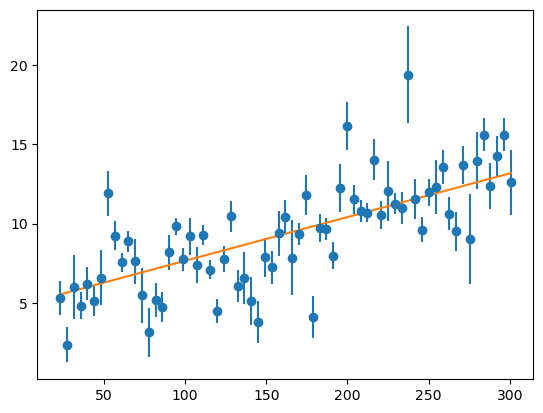

In [33]:
w1 = velocity_cropped.isel(time=30, attenuator_setting_pair=0)
plt.errorbar(x=w1.bin_depth, y=w1.velocity, yerr=w1.velocity_uncertainty, marker='o', label='data', linestyle='None')
plt.plot(w1.bin_depth, np.polyval(polyfit(w1).parameters.values, w1.bin_depth), label='fit')

polyfit(w1).parameter_uncertainty.sel(degree=0).item()

`.sel` seems like a faster option that `.where`. 

## Testing the new implementation in utils/py

In [34]:
from_utils = stacked.profile.displacement_timeseries(max_depth_for_ezz_fit = 300, offset = 6)

In [36]:
from_utils.strain_rate.isel(attenuator_setting_pair=1, time=60)

<xarray.DataArray 'strain_rate' ()>
array(0.02081771)
Coordinates:
    folder_name  <U4 'Data'
    AFGain       int64 -14
    attenuator   float64 10.0
    orientation  <U7 'unknown'
    time         datetime64[ns] 2024-12-11T07:01:48
Attributes:
    units:                         1/year
    long_name:                     vertical strain rate computed between 0.0 ...
    max_depth_for_ezz_fit_meters:  300
    min_depth_for_ezz_fit_meters:  0.0

In [ ]:
one_w = w.isel(attenuator_setting_pair=1, time=60).sel(bin_depth=slice(0, 300))

polyfit(one_w, cov = 'unscaled')

<xarray.Dataset>
Dimensions:                (degree: 2)
Coordinates:
    folder_name            <U4 'Data'
    AFGain                 int64 -14
    attenuator             float64 10.0
    orientation            <U7 'unknown'
    time                   datetime64[ns] 2024-12-11T07:01:48
Dimensions without coordinates: degree
Data variables:
    parameters             (degree) float64 0.02082 -1.349
    parameter_uncertainty  (degree) float64 0.001144 0.1851
    polyfit_residuals      float64 390.5

In [44]:
xa.utils.computeStrainRates(xr.merge([one_w.velocity, one_w.velocity_uncertainty]),
                                      max_depth_for_ezz_fit = 300, 
                                      min_depth_for_ezz_fit = 0, 
                                      lower_limit_on_fit = None)

<xarray.Dataset>
Dimensions:                        ()
Coordinates:
    folder_name                    <U4 'Data'
    AFGain                         int64 -14
    attenuator                     float64 10.0
    orientation                    <U7 'unknown'
    time                           datetime64[ns] 2024-12-11T07:01:48
Data variables:
    strain_rate                    float64 0.02082
    strain_rate_uncertainty        float64 0.001144
    surface_intercept              float64 -1.349
    surface_intercept_uncertainty  float64 0.1851
    r_squared                      float64 0.1873
Attributes:
    units:                         1/year
    long_name:                     vertical strain rate computed between 0 an...
    max_depth_for_ezz_fit_meters:  300
    min_depth_for_ezz_fit_meters:  0

In [45]:
polyfit(w.sel(bin_depth=slice(0, 300))).isel(attenuator_setting_pair=1, time=60)

<xarray.Dataset>
Dimensions:                (degree: 2)
Coordinates:
    folder_name            <U4 'Data'
    AFGain                 int64 -14
    attenuator             float64 10.0
    orientation            <U7 'unknown'
    time                   datetime64[ns] 2024-12-11T07:01:48
Dimensions without coordinates: degree
Data variables:
    parameters             (degree) float64 0.02082 -1.349
    parameter_uncertainty  (degree) float64 0.001144 0.1851
    polyfit_residuals      float64 390.5

In [ ]:
abs_weights

,scipy,numpy,xarray,apply_ufunc
slope,0.020818,0.020818,0.020818,0.020818
intercept,-1.349183,-1.349183,-1.349183,-1.349183
sigma_slope,0.001144,0.001144,0.001144,0.001144
sigma_intercept,0.185069,0.185069,0.185069,0.185069


In [ ]:
#one_w = w.isel(attenuator_setting_pair=1, time=60).sel(bin_depth=slice(0,300))


## Trying statsmodels to plot confidence intervals

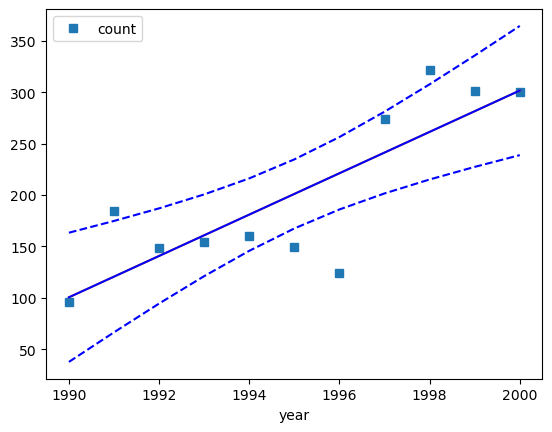

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

df = pd.DataFrame({'year':['1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000'],
                   'count':[96,184,148,154,160,149,124,274,322,301,300]})
df['year'] = df['year'].astype(float)
X = sm.add_constant(df['year'].values)
ols_model = sm.OLS(df['count'].values, X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

fig, ax = plt.subplots()
df.plot(x='year',y='count',linestyle='None',marker='s', ax=ax)
y_pred = est.predict(X)
x_pred = df.year.values
ax.plot(x_pred,y_pred)

pred = est.get_prediction(X).summary_frame()
ax.plot(x_pred,pred['mean_ci_lower'],linestyle='--',color='blue')
ax.plot(x_pred,pred['mean_ci_upper'],linestyle='--',color='blue')

# Alternative way to plot
def line(x,b=0,m=1):
    return m*x+b

ax.plot(x_pred,line(x_pred,est.params[0],est.params[1]),color='blue')



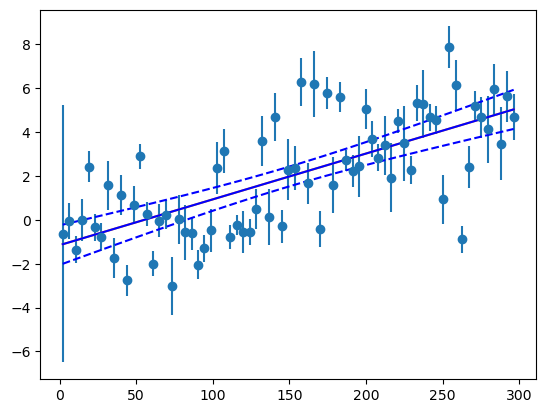

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

#df = pd.DataFrame({'year':['1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000'],
#                   'count':[96,184,148,154,160,149,124,274,322,301,300]})
#df['year'] = df['year'].astype(float)
X = sm.add_constant(xdata)
ols_model = sm.OLS(ydata, X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

fig, ax = plt.subplots()
plt.errorbar(x=xdata, y=ydata, yerr=sigma, marker='o', label='data', linestyle='None')
y_pred = est.predict(X)
x_pred = xdata
ax.plot(x_pred, y_pred)

pred = est.get_prediction(X).summary_frame()
ax.plot(x_pred, pred['mean_ci_lower'],linestyle='--',color='blue')
ax.plot(x_pred, pred['mean_ci_upper'],linestyle='--',color='blue')

# Alternative way to plot
def line(x,b=0,m=1):
    return m*x+b

ax.plot(x_pred,line(x_pred,est.params[0],est.params[1]),color='blue')



In [ ]:
dir(est)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_get_wald_nonlinear',
 '_is_nested',
 '_transform_predict_exog',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 '

In [ ]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     63.36
Date:                Tue, 04 Mar 2025   Prob (F-statistic):           2.37e-11
Time:                        16:24:00   Log-Likelihood:                -145.50
No. Observations:                  71   AIC:                             295.0
Df Residuals:                      69   BIC:                             299.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1525      0.452     -2.550      0.0

In [ ]:
est.get_prediction(X).summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,-1.110772,0.447509,-2.003529,-0.218016,-5.015259,2.793714
1,-1.022944,0.438023,-1.896776,-0.149111,-4.923147,2.877259
2,-0.935115,0.428611,-1.790171,-0.080059,-4.831155,2.960924
3,-0.847287,0.419279,-1.683724,-0.010849,-4.739282,3.044709
4,-0.759458,0.410030,-1.577446,0.058530,-4.647530,3.128614
...,...,...,...,...,...,...
66,4.685917,0.410030,3.867929,5.503905,0.797845,8.573989
67,4.773746,0.419279,3.937308,5.610184,0.881750,8.665741
68,4.861574,0.428611,4.006518,5.716631,0.965535,8.757614
69,4.949403,0.438023,4.075570,5.823235,1.049200,8.849606
